In [1]:
# !pip install imgur-downloader
# !pip install python-magic
# !apt install libmagic-dev

In [2]:
# no web cache, file check instead

In [3]:
from pymongo import MongoClient
import requests
from pathlib import Path
import glob
from PIL import Image
from io import BytesIO
import magic
from imgur_downloader import ImgurDownloader

from lib.parallel import parallel

In [4]:
mongo = MongoClient('172.17.0.1', 27017)
db = mongo['bad-vis']
posts = db['posts']
dlthumbnailresults = db['dlthumbnailresults']
dlpreviewresults = db['dlpreviewresults']
dlexternalresults = db['dlexternalresults']

In [5]:
images_dir = Path('./images')

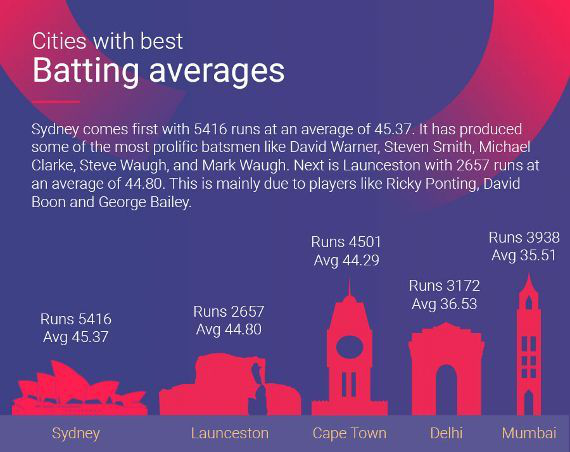

In [6]:
post = posts.find_one()
r = requests.get(post['preview']['url'])
pil_image = Image.open(BytesIO(r.content))
pil_image

In [7]:
ImgurDownloader('http://imgur.com/(null)')

In [8]:
def get_content_type_ext (content_type, req=None):
    content_type = content_type.lower()
    if content_type.startswith('image/jpeg') or content_type.startswith('image/jpg'):
        return '.jpg'
    elif content_type.startswith('image/png'):
        return '.png'
    elif content_type.startswith('image/gif'):
        return '.gif'
    elif content_type.startswith('image/webp'):
        return '.webp'
    elif content_type.startswith('image/svg'):
        return '.svg'
    elif content_type.startswith('image/bmp'):
        return '.bmp'
    elif req:
        return get_content_type_ext(magic.from_buffer(req.content, mime=True))
    elif content_type.startswith('text/html'):
        return '.html'
    elif content_type.startswith('application/pdf'):
        return '.pdf'
    else:
        print(f'Unknow content-type: {content_type}')
        return ''

def download_image (post, t='preview', outdir=None):
    if t in post:
        if type(post[t]) == str:
            link = post[t]
        else:
            link = post[t]['url']
    else:
        link = ''
    if not outdir:
        outdir = t
    result = {
        'id': post['id'],
        'post_id': post['post_id'],
        'link': link,
        'dest': images_dir/outdir/post['post_id']
    }

    if len(glob.glob(f'{result["dest"]}*')) != 0:
        result['status'] = 'exists'
        return result
    else:
        result['dest'].parent.mkdir(parents=True, exist_ok=True)

    if not link or link == 'None' or type(link) != str:
        result['status'] = 'invalid_url'
        return result

    try:
        if t == 'external_link':
            if 'imgur.com' in link and not (link.endswith('.jpg') or link.endswith('.png')):
                filename, skipped = ImgurDownloader(link,
                                                    dir_download=result['dest'].parent,
                                                    file_name=result['id'],
                                                    delete_dne=True).save_images()
                if skipped != 0:
                    result['status'] = 'imgur_dne'
                else:
                    result['status'] = 'downloaded'
                return result
            elif 'viz.wtf' in link:
                result['status'] = 'skip_wtf-viz'
                return result
            elif 'twitter.com' in link:
                result['status'] = 'skip_twitter'
                return result
            elif 'youtube.com' in link or 'youtu.be' in link:
                result['status'] = 'skip_youtube'
                return result
            elif 'vimeo.com' in link:
                result['status'] = 'skip_vimeo'
                return result
            elif 'reddit.com/r' in link:
                result['status'] = 'skip_subreddit'
                return result
            elif 'reddit.com/user' in link:
                result['status'] = 'skip_redditor'
                return result

        r = requests.get(link, timeout=30)
        result['request_status'] = r.status_code
        if result['request_status'] >= 400:
            if result['request_status'] == 404:
                result['status'] = 'not_found'
            else:
                result['status'] = 'http_error'
            return result

        result['ext'] = get_content_type_ext(r.headers.get('content-type'), r)
        if result['ext'] == '':
            result['status'] = 'invalid_content_type'
            print(f'id: {result["id"]} link: {result["link"]}')
            return result
        if result['ext'] == '.html' or result['ext'] == '.pdf':
            result['status'] = 'skip_content_type'
            return result

        result['output'] = f'{result["dest"]}{result["ext"]}'
        with open(result['output'], 'wb') as f:
            f.write(r.content)
        result['status'] = 'downloaded'
        return result
    except Exception as inst:
        print(f"Download error: {post['post_id']} {link} {inst}")
        result['status'] = 'download_error'
        return result

    return result

In [9]:
for post in [posts.find_one()]:
    result = download_image(post, t='preview')
    print(result)

{'id': 187107071331, 'post_id': 'tumblr/badvisualisations/187107071331', 'link': 'https://66.media.tumblr.com/1a2eaf8a9098222c050b5f978b628d59/tumblr_pwgj5bXRBJ1xbq2wwo1_640.jpg', 'dest': PosixPath('images/preview/tumblr/badvisualisations/187107071331'), 'status': 'exists'}


In [10]:
for post in [posts.find_one()]:
    result = download_image(post, t='preview')
    print(result)

{'id': 187107071331, 'post_id': 'tumblr/badvisualisations/187107071331', 'link': 'https://66.media.tumblr.com/1a2eaf8a9098222c050b5f978b628d59/tumblr_pwgj5bXRBJ1xbq2wwo1_640.jpg', 'dest': PosixPath('images/preview/tumblr/badvisualisations/187107071331'), 'status': 'exists'}


In [11]:
for post in [posts.find_one()]:
    result = download_image(post, t='thumbnail')
    print(result)

{'id': 187107071331, 'post_id': 'tumblr/badvisualisations/187107071331', 'link': 'https://66.media.tumblr.com/1a2eaf8a9098222c050b5f978b628d59/tumblr_pwgj5bXRBJ1xbq2wwo1_250.jpg', 'dest': PosixPath('images/thumbnail/tumblr/badvisualisations/187107071331'), 'status': 'exists'}


In [12]:
!ls -al images/external_link/reddit/dataisugly/6flghc.mp4

ls: cannot access 'images/external_link/reddit/dataisugly/6flghc.mp4': No such file or directory


In [13]:
!rm 'images/external_link/reddit/dataisugly/6flghc.mp4'

rm: cannot remove 'images/external_link/reddit/dataisugly/6flghc.mp4': No such file or directory


In [14]:
for post in [posts.find_one({'id': '37burb'})]:
    result = download_image(post, t='external_link', outdir='external_link')
    print(result)

{'id': '37burb', 'post_id': 'reddit/dataisugly/37burb', 'link': 'http://imgur.com/7wJ9Fci', 'dest': PosixPath('images/external_link/reddit/dataisugly/37burb'), 'status': 'exists'}


In [15]:
dl_preview_results = parallel(download_image, posts.find(), params_dict={'t': 'preview', 'outdir': 'preview'}, total=posts.estimated_document_count(), n_jobs=20)

In [16]:
dl_thumbnail_results = parallel(download_image, posts.find(), params_dict={'t': 'thumbnail', 'outdir': 'thumbnail'}, total=posts.estimated_document_count(), n_jobs=20)

In [17]:
dl_external_link_results = parallel(download_image, posts.find(), params_dict={'t': 'external_link', 'outdir': 'external_link'}, total=posts.estimated_document_count(), n_jobs=20)

Download error: reddit/dataisugly/ariceq http://www.vairalm/live HTTPConnectionPool(host='www.vairalm', port=80): Max retries exceeded with url: /live (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f0cf0492ad0>: Failed to establish a new connection: [Errno -2] Name or service not known'))
Download error: reddit/solar/93g36i http://www.landartgenerator.org/blagi/wp-content/uploads/2009/08/AreaRequired1000.jpg HTTPSConnectionPool(host='www.landartgenerator.org', port=443): Max retries exceeded with url: /blagi/wp-content/uploads/2009/08/AreaRequired1000.jpg (Caused by SSLError(SSLCertVerificationError("hostname 'www.landartgenerator.org' doesn't match 'landartgenerator.org'")))
Download error: reddit/dataisugly/93kjii http://www.landartgenerator.org/blagi/wp-content/uploads/2009/08/AreaRequired1000.jpg HTTPSConnectionPool(host='www.landartgenerator.org', port=443): Max retries exceeded with url: /blagi/wp-content/uploads/2009/08/AreaRequired1000.jpg (Cause

In [18]:
dl_results = [
    (dl_preview_results, dlthumbnailresults),
    (dl_thumbnail_results, dlpreviewresults),
    (dl_external_link_results, dlexternalresults)
]

for results, outdb in dl_results:
    for r in results:
        r['dest'] = str(r['dest'])

    outdb.drop()
    outdb.insert_many(results)